## Project Reinforcement Learning 

Group 7 - Willem Huijzer, Joris Holshuijsen, Max Feucht


In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch

from evaluate import RuleEvaluation, DDQNEvaluation, Plotter
from agent import DDQNAgent

import gym_env

seed = 2705
TRAIN = False

### Setting up the environment:

- 50kWh of usable capacity 
- 90% efficiency of the battery (both ways)
- The maximum power available is 25kW (both ways - pertains to charging and discharging. One hour, we charge and discharge 25kWh) 
- Prices are in MWh! --> Rescale
- Electricity is sold at the spot market price
- Electricity is bought at twice the price to pay for the transmission costs and various taxes.
- Only data up to the current time step available
- Day: 8am to 6pm
- Night: 6pm - 8am
- 50% of days, car is not available during the day and returns with 20kWh less
- Minimum capacity at 8am: 20kWh (if charge < 20kwH, charge from 7am to 8am)


### Open Questions:

- Intensity at which to sell or buy (Always 25kW, does it make sense to sell / buy less over a longer period of time)
- What reward to give when trying to charge / sell during the day when car is absent. Do we give a penalty for even trying or do we let it do whatever it wants?

In [2]:
# Load Data

def elongate(df):
    df_long = pd.wide_to_long(df, i = "PRICES", j = "hour", stubnames=["Hour"], sep = " ").reset_index()
    df_long.rename(columns={"Hour": "price", "PRICES": "date"}, inplace = True)
    df_long['datetime'] = pd.to_datetime(df_long['date']) + pd.to_timedelta(df_long['hour'], unit='h')
    df_long.sort_values(['datetime'], ascending=[True], inplace=True)
    df_long['price'] = df_long['price'].astype(float) / 1000 # Convert price per MWh to price per KWh
    return df_long.reset_index(drop=True)

train = elongate(pd.read_excel('data/train.xlsx'))
val = elongate(pd.read_excel('data/validate.xlsx'))


## RULE BASED AGENT

In [3]:
# Evaluate Rule-Based Agent
price_horizon = 24
df = train

rule_env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
rule_env.setup(df, price_horizon=price_horizon, action_classes = 13)
eval_rule = RuleEvaluation(df, rule_env)
eval_rule.evaluate(low_quantile = 0.25, high_quantile = 0.75)


/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.price_horizon to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.price_horizon` for environment variables or `env.get_wrapper_attr('price_horizon')` that will search the reminding wrappers.
  logger.warn(


Setup with price horizon:  24  and future horizon:  0  and action space:  13
Absolute Balance:  -786.488425853889


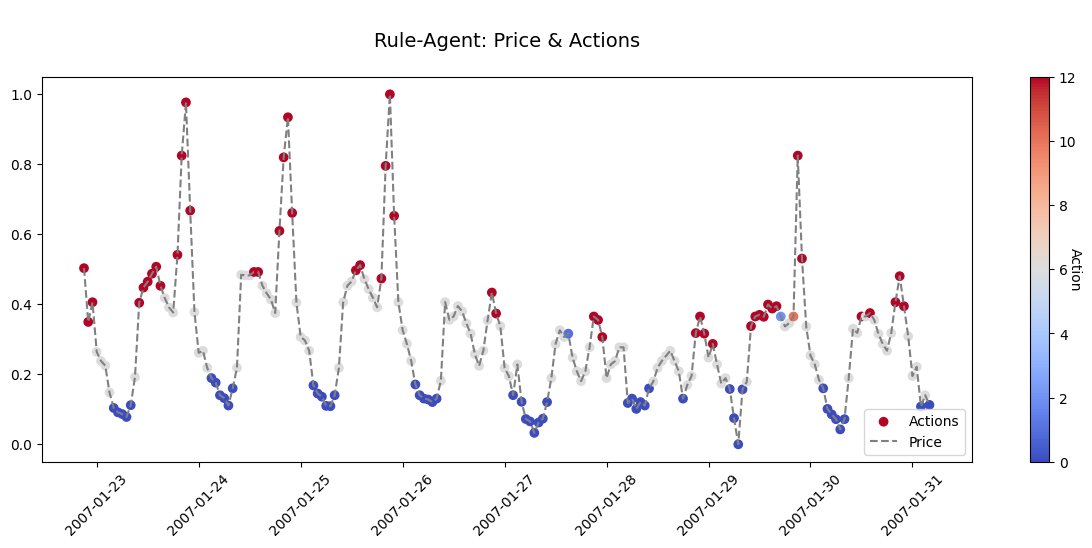

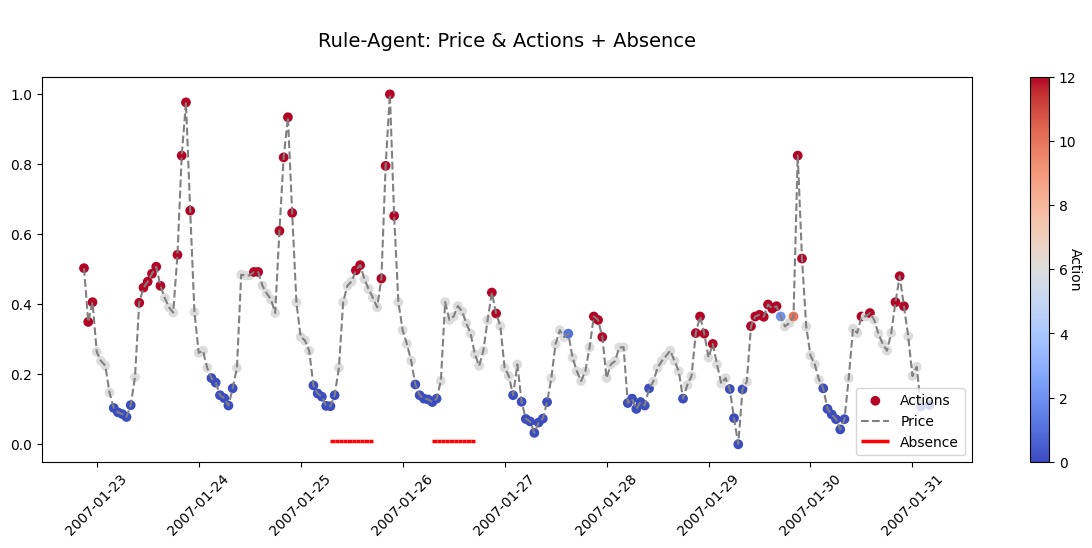

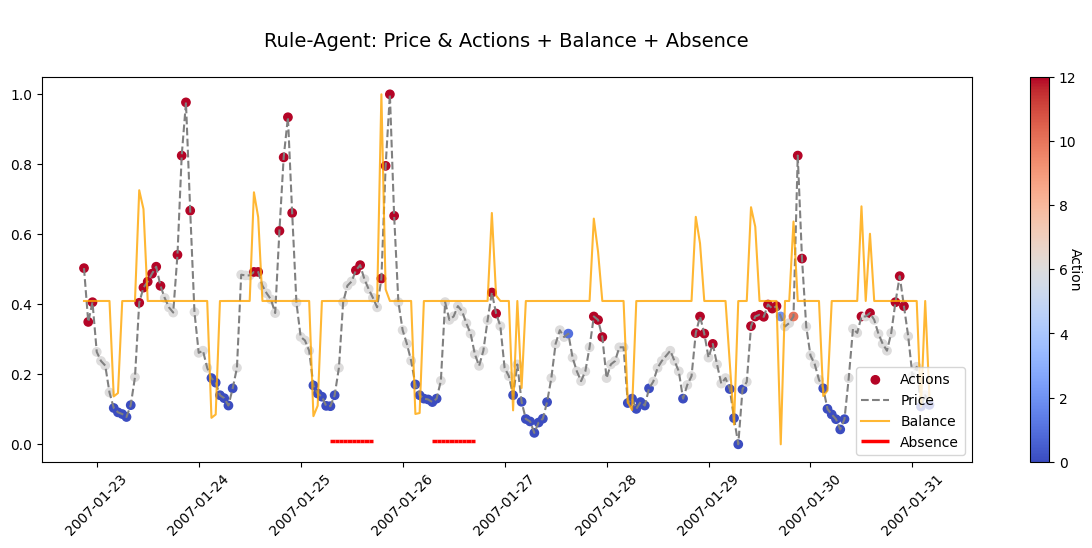

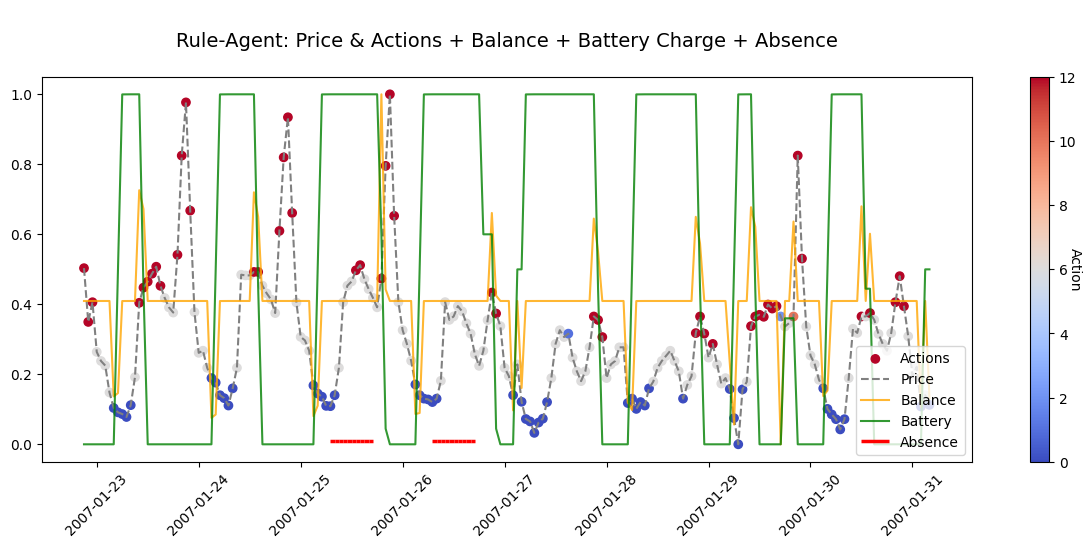

In [4]:
# Visualize Rule-Based Agent
plot_range = (500, 700)

plotter = Plotter(eval_rule, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

## DDQN AGENT

In [9]:
seed = 2705
rep = 1000000
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_decay = 49999
epsilon_min = 0.05
learning_rate = 5e-5
price_horizon = 120
future_horizon = 0
hidden_dim = 64
action_classes = 5
extra_penalty = False
verbose = False
TRAIN = True

In [10]:
if TRAIN:
    
    # Initialize Environment
    env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
    env.setup(train, price_horizon=price_horizon, future_horizon=future_horizon, action_classes = action_classes, extra_penalty = extra_penalty)

    #Initialize DQN
    agent = DDQNAgent(env = env, 
                    device = 'cpu', 
                    epsilon_decay = epsilon_decay, 
                    epsilon_start = epsilon, 
                    epsilon_end = epsilon_min, 
                    discount_rate = gamma, 
                    lr = learning_rate, 
                    buffer_size = 50000, 
                    price_horizon = price_horizon, 
                    hidden_dim=hidden_dim,
                    action_classes = action_classes)
        
    obs, info = env.reset() # Reset environment and get initial observation

    episode_balance = 0
    episode_loss = 0
    episode_counter = 0
    episode_reward = 0

    with tqdm(total=rep) as pbar:
        for i in range(rep):
            
            action = agent.choose_action(i, obs['tensor'], greedy = False)
            new_obs,r,t,info = env.step(action)

            # Fill replay buffer - THIS IS THE ONLY THING WE DO WITH THE CURRENT OBSERVATION - LEARNING IS FULLY PERFORMED FROM THE REPLAY BUFFER
            agent.replay_memory.add_data((obs['tensor'], action, r, t, new_obs['tensor']))
            
            #Update DQN
            loss = agent.optimize(batch_size)
            
            # Update values
            episode_balance += info['balance']
            episode_reward += r
            episode_loss += loss
            
            # New observation
            obs = new_obs

            pbar.update(1)
            
            if t:
                obs, info = env.reset()
                episode_counter += 1
                print('Episode ', episode_counter, 'Balance: ', episode_balance, 'Reward: ', episode_reward, 'Loss: ', episode_loss) # Add both balance and reward to see how training objective and actually spent money differ
                episode_loss = 0
                episode_balance = 0
                episode_reward = 0 
            
    # Save agent
    torch.save(agent.dqn_predict.state_dict(), f'models/agent_{action_classes}_hdim{hidden_dim}_ph{price_horizon}.pt')
    pbar.close()


Setup with price horizon:  120  and future horizon:  0  and action space:  5


  0%|          | 0/1000000 [00:00<?, ?it/s]

  3%|▎         | 26255/1000000 [01:07<36:08, 449.13it/s]  

Episode  1 Balance:  -6663.314996448434 Reward:  -6663.314996448434 Loss:  17837.00881508831


  5%|▌         | 52442/1000000 [02:24<47:12, 334.50it/s]  

Episode  2 Balance:  -3050.624089063011 Reward:  -3050.624089063011 Loss:  11758.56106271036


  8%|▊         | 78634/1000000 [03:30<33:21, 460.25it/s]  

Episode  3 Balance:  -1438.1356765544408 Reward:  -1438.1356765544408 Loss:  10563.422433095053


 10%|█         | 104798/1000000 [04:32<31:17, 476.72it/s] 

Episode  4 Balance:  -1233.6423053943354 Reward:  -1233.6423053943354 Loss:  7337.389153284952


 13%|█▎        | 130961/1000000 [05:34<32:33, 444.91it/s]  

Episode  5 Balance:  -1270.1310508577776 Reward:  -1270.1310508577776 Loss:  3247.1253764489666


 16%|█▌        | 157141/1000000 [06:47<46:20, 303.16it/s]  

Episode  6 Balance:  -1139.2419518004451 Reward:  -1139.2419518004451 Loss:  3547.631213121582


 18%|█▊        | 183368/1000000 [07:55<29:21, 463.72it/s]  

Episode  7 Balance:  -1175.3778195486648 Reward:  -1175.3778195486648 Loss:  3682.3911817856133


 21%|██        | 209540/1000000 [08:59<29:48, 441.93it/s]  

Episode  8 Balance:  -998.0643476332232 Reward:  -998.0643476332232 Loss:  2868.6572365183383


 24%|██▎       | 235721/1000000 [10:11<32:35, 390.82it/s]  

Episode  9 Balance:  -1065.6122854550006 Reward:  -1065.6122854550006 Loss:  2757.5018074326217


 26%|██▌       | 261900/1000000 [11:22<29:50, 412.13it/s]  

Episode  10 Balance:  -1165.816478592554 Reward:  -1165.816478592554 Loss:  2561.477309157606


 29%|██▉       | 288063/1000000 [12:29<32:21, 366.73it/s]  

Episode  11 Balance:  -1014.6841551590026 Reward:  -1014.6841551590026 Loss:  3262.033056254033


 31%|███▏      | 314260/1000000 [13:52<32:49, 348.15it/s]  

Episode  12 Balance:  -1011.2405877697767 Reward:  -1011.2405877697767 Loss:  4020.623525217641


 34%|███▍      | 340450/1000000 [15:06<24:48, 443.16it/s]  

Episode  13 Balance:  -1026.8575160758883 Reward:  -1026.8575160758883 Loss:  5806.141010243911


 37%|███▋      | 366668/1000000 [16:32<24:22, 433.04it/s]  

Episode  14 Balance:  -961.0121410051096 Reward:  -961.0121410051096 Loss:  6003.574176623486


 39%|███▉      | 392817/1000000 [17:41<22:35, 448.08it/s]  

Episode  15 Balance:  -994.8258743099997 Reward:  -994.8258743099997 Loss:  4564.034442024771


 42%|████▏     | 418964/1000000 [18:56<31:11, 310.54it/s]  

Episode  16 Balance:  -979.1844924253325 Reward:  -979.1844924253325 Loss:  4916.73068014998


 45%|████▍     | 445187/1000000 [20:16<21:18, 434.00it/s]  

Episode  17 Balance:  -975.4849771956672 Reward:  -975.4849771956672 Loss:  5941.853080694564


 47%|████▋     | 471382/1000000 [21:31<19:12, 458.48it/s]  

Episode  18 Balance:  -1005.6286495460045 Reward:  -1005.6286495460045 Loss:  5365.2772553619


 50%|████▉     | 497570/1000000 [22:38<18:03, 463.76it/s]

Episode  19 Balance:  -881.775414593779 Reward:  -881.775414593779 Loss:  4837.448759876192


 52%|█████▏    | 523741/1000000 [23:47<21:08, 375.36it/s]  

Episode  20 Balance:  -901.2735341926668 Reward:  -901.2735341926668 Loss:  4358.030052090995


 55%|█████▍    | 549937/1000000 [24:55<15:30, 483.43it/s]  

Episode  21 Balance:  -959.4352018460021 Reward:  -959.4352018460021 Loss:  4358.196379996836


 58%|█████▊    | 576104/1000000 [25:56<16:09, 437.31it/s]

Episode  22 Balance:  -1020.5548519303342 Reward:  -1020.5548519303342 Loss:  4443.1778734130785


 60%|██████    | 602313/1000000 [26:50<15:09, 437.45it/s]

Episode  23 Balance:  -981.9974147868883 Reward:  -981.9974147868883 Loss:  4394.0287876026705


 63%|██████▎   | 628475/1000000 [27:50<13:18, 465.39it/s]

Episode  24 Balance:  -1095.1928732664453 Reward:  -1095.1928732664453 Loss:  4779.064920910634


 65%|██████▌   | 654653/1000000 [28:50<12:07, 474.97it/s]

Episode  25 Balance:  -1136.859246139221 Reward:  -1136.859246139221 Loss:  4630.9589704200625


 68%|██████▊   | 680810/1000000 [30:08<35:36, 149.41it/s]

Episode  26 Balance:  -1184.2424821172228 Reward:  -1184.2424821172228 Loss:  6829.869292624295


 71%|███████   | 707051/1000000 [31:45<11:37, 419.84it/s] 

Episode  27 Balance:  -1269.3867351965544 Reward:  -1269.3867351965544 Loss:  7226.894116750918


 73%|███████▎  | 733226/1000000 [33:01<11:40, 381.07it/s] 

Episode  28 Balance:  -1112.228787226776 Reward:  -1112.228787226776 Loss:  5151.96729059238


 76%|███████▌  | 759382/1000000 [33:58<08:38, 464.50it/s]

Episode  29 Balance:  -1077.5666841737773 Reward:  -1077.5666841737773 Loss:  3789.592145952396


 79%|███████▊  | 785579/1000000 [35:15<09:16, 385.39it/s]

Episode  30 Balance:  -997.8844744502195 Reward:  -997.8844744502195 Loss:  4313.871451175772


 81%|████████  | 811713/1000000 [36:52<13:15, 236.61it/s]

Episode  31 Balance:  -1034.7706823179976 Reward:  -1034.7706823179976 Loss:  6453.145423761569


 84%|████████▍ | 837937/1000000 [38:14<05:45, 469.21it/s]

Episode  32 Balance:  -1142.5717770859994 Reward:  -1142.5717770859994 Loss:  5244.266447494738


 86%|████████▋ | 864129/1000000 [39:22<05:49, 389.03it/s]

Episode  33 Balance:  -1136.1535640439972 Reward:  -1136.1535640439972 Loss:  5841.824682851322


 89%|████████▉ | 890323/1000000 [40:28<04:12, 433.67it/s]

Episode  34 Balance:  -1085.975052092329 Reward:  -1085.975052092329 Loss:  6583.349273113534


 92%|█████████▏| 916489/1000000 [41:32<03:25, 405.55it/s]

Episode  35 Balance:  -1097.8864868147766 Reward:  -1097.8864868147766 Loss:  4782.330936357379


 94%|█████████▍| 942691/1000000 [42:38<02:33, 374.38it/s]

Episode  36 Balance:  -1036.2322862345557 Reward:  -1036.2322862345557 Loss:  4377.622640904505


 97%|█████████▋| 968859/1000000 [43:42<01:12, 431.89it/s]

Episode  37 Balance:  -1059.1701931704442 Reward:  -1059.1701931704442 Loss:  5660.466535766609


100%|█████████▉| 995101/1000000 [44:32<00:08, 558.07it/s]

Episode  38 Balance:  -1105.5507983381126 Reward:  -1105.5507983381126 Loss:  6268.939187456388


100%|██████████| 1000000/1000000 [44:42<00:00, 372.85it/s]


In [13]:
# Initialize Environment (needed for Replay Buffer)
env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
env.setup(train, price_horizon=price_horizon, future_horizon=future_horizon, action_classes = action_classes, extra_penalty = extra_penalty)

# Load agent
agent = DDQNAgent(env = env,
                  device = 'cpu', 
                  epsilon_decay = epsilon_decay, 
                  epsilon_start = epsilon, 
                  epsilon_end = epsilon_min, 
                  discount_rate = gamma, 
                  lr = learning_rate, 
                  buffer_size = 50000, 
                  price_horizon = price_horizon, 
                  hidden_dim=hidden_dim,
                  action_classes = action_classes)

agent.dqn_predict.load_state_dict(torch.load(f'models/agent_{action_classes}_hdim{hidden_dim}_ph{price_horizon}.pt'))


Setup with price horizon:  120  and future horizon:  0  and action space:  5


<All keys matched successfully>

In [14]:
# Evaluate DDQN Agent
df = train

ddqn_env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
ddqn_env.setup(train, price_horizon=price_horizon, future_horizon=future_horizon, action_classes = action_classes, extra_penalty = False)
eval_ddqn = DDQNEvaluation(df, ddqn_env)
eval_ddqn.evaluate(agent = agent)

Setup with price horizon:  120  and future horizon:  0  and action space:  5
Absolute Balance:  -759.4268044652222


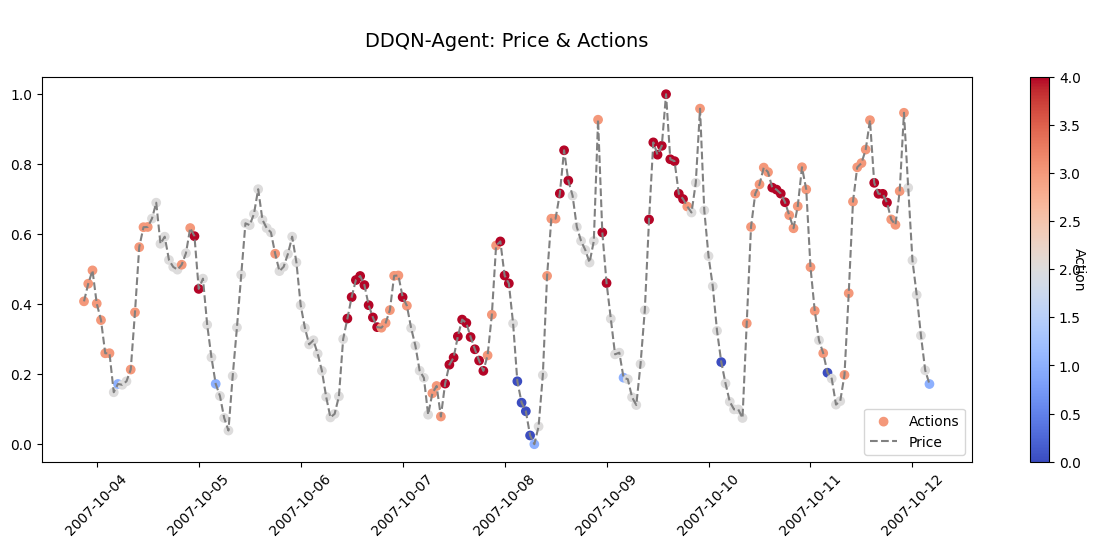

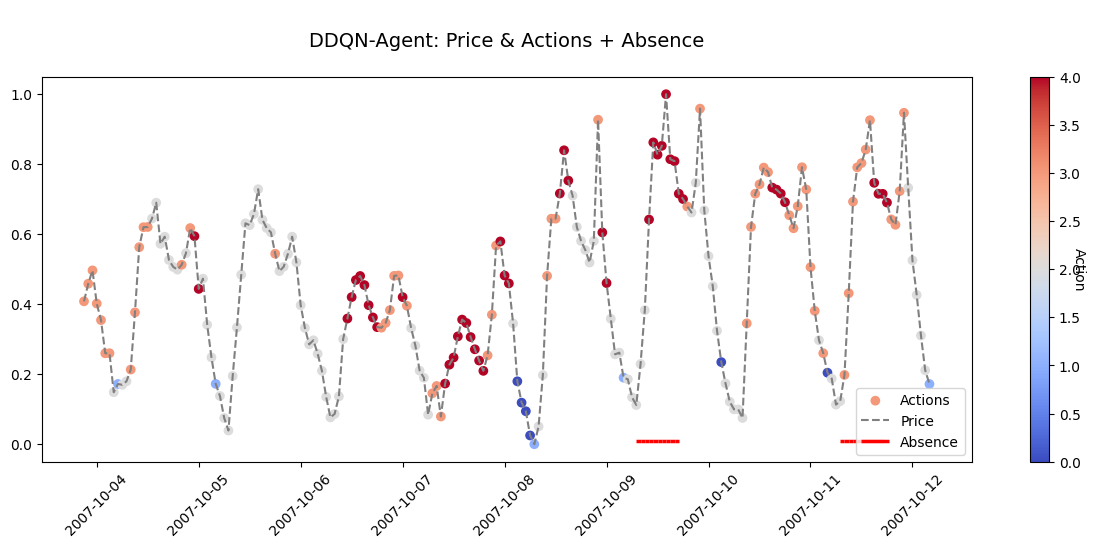

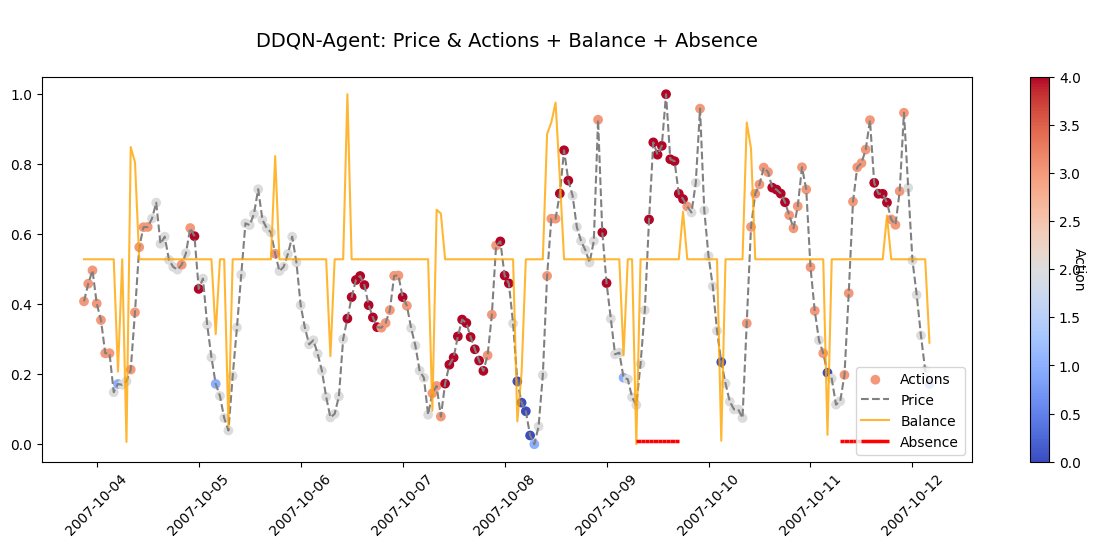

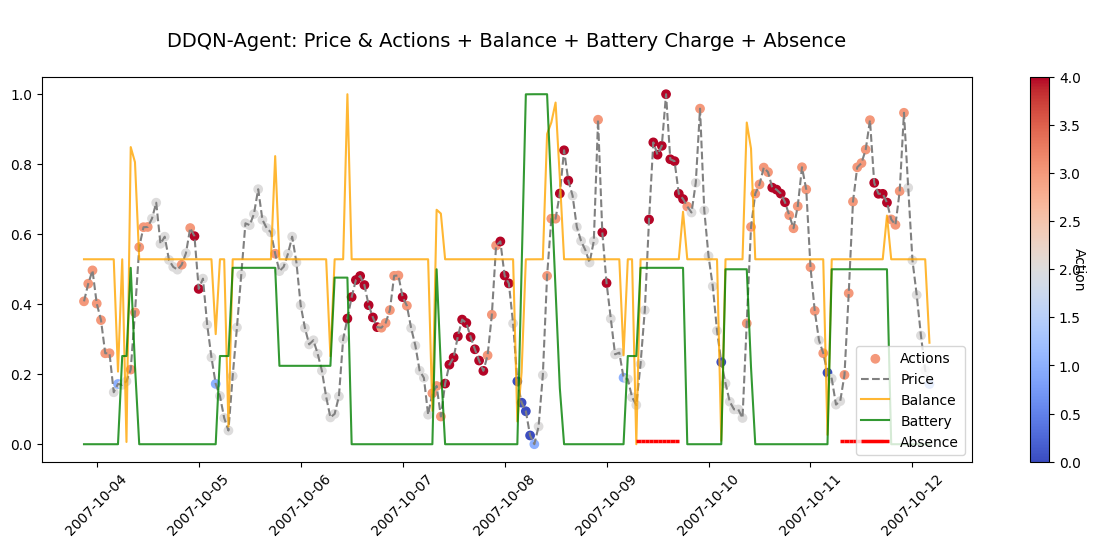

In [15]:
#Visualize DDQN Agent
plot_range = [6500, 6700]

plotter = Plotter(eval_ddqn, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

# VALIDATION

Setup with price horizon:  24  and future horizon:  0  and action space:  13
Absolute Balance:  -1060.0511817065556


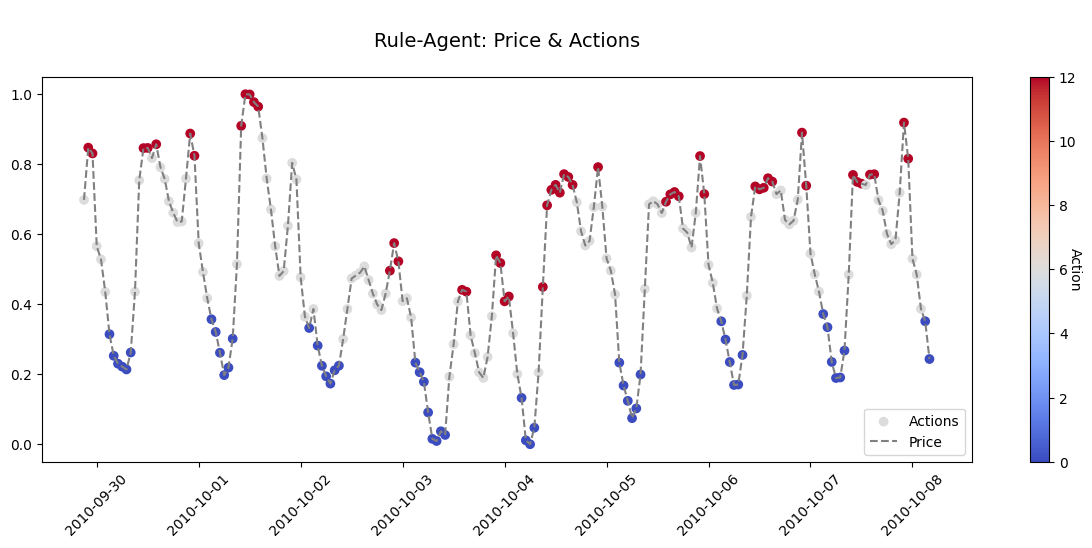

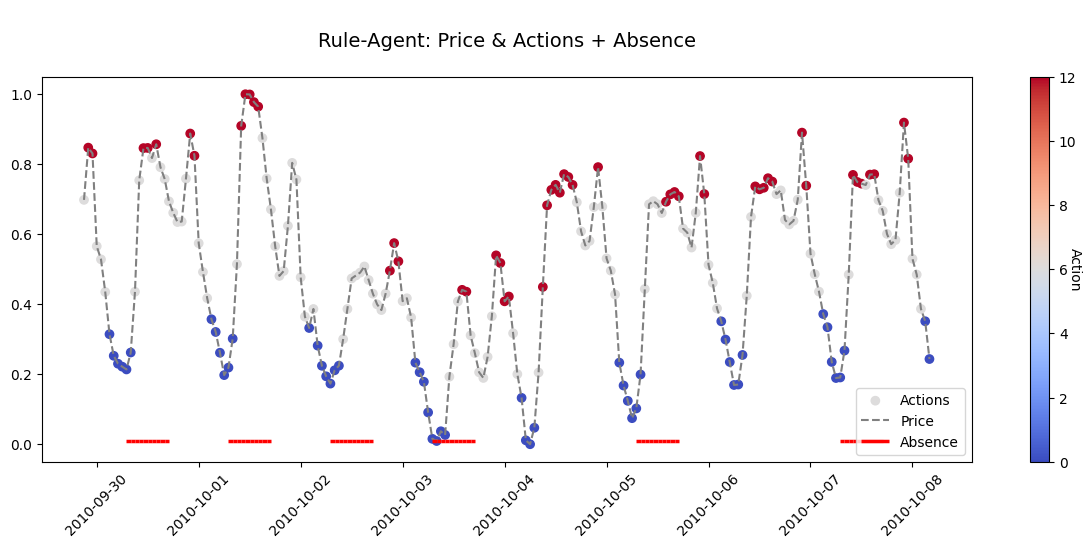

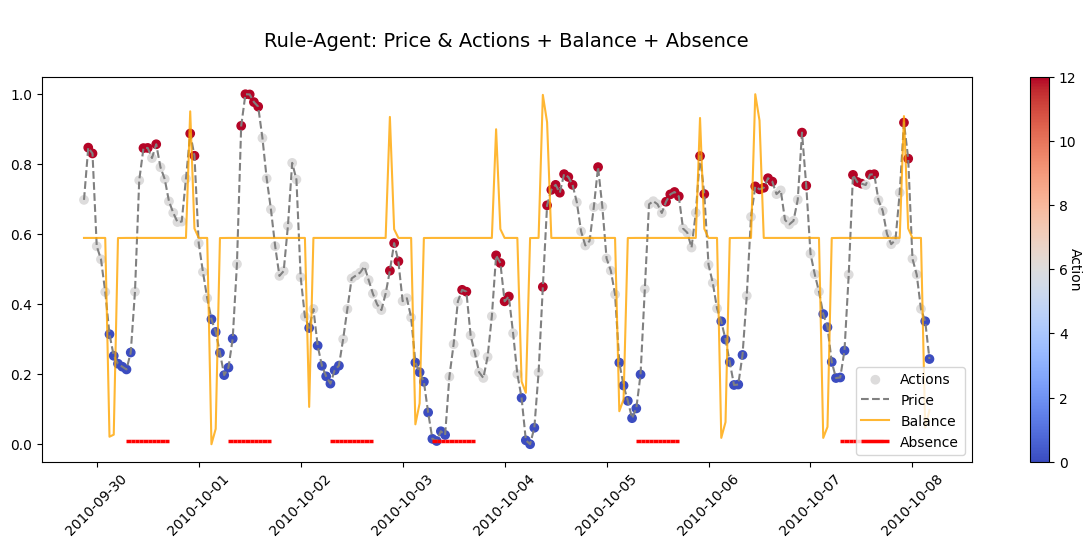

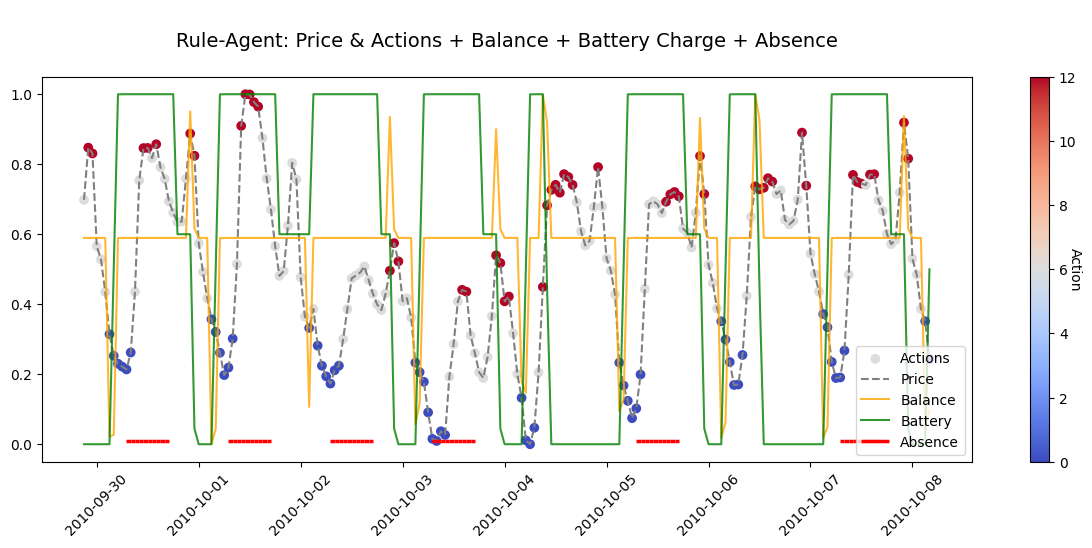

In [16]:
# Evaluate Rule-Based Agent
price_horizon = 24
df = val

rule_env_val = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
rule_env_val.setup(df, price_horizon=price_horizon, action_classes = 13)
eval_rule_val = RuleEvaluation(df, rule_env_val)
eval_rule_val.evaluate(low_quantile = 0.25, high_quantile = 0.75)

#Visualize DDQN Agent
plot_range = [6500, 6700]

plotter = Plotter(eval_rule_val, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)


In [17]:
# Evaluate DDQN Agent
price_horizon = 48
action_classes = 5
df = val

ddqn_env_val = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
ddqn_env_val.setup(df, price_horizon=price_horizon, action_classes = action_classes)
eval_ddqn_val = DDQNEvaluation(df, ddqn_env_val)
eval_ddqn_val.evaluate(agent = agent)

#Visualize DDQN Agent
plot_range = [6500, 6700]

plotter = Plotter(eval_ddqn_val, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

Setup with price horizon:  48  and future horizon:  0  and action space:  5


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x54 and 126x64)

In [ ]:
## To Do:

# Improve efficiency of environment
# 

# Sanity Check of Environment

In [10]:
action_classes = 11
test_env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
test_env.setup(df, price_horizon=price_horizon, extra_penalty = True, action_classes = action_classes, verbose = True)
obs, info = test_env.reset()

for k in range(4):
    for i in reversed(range(action_classes)):
        test_env.step(i)


/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(


Setup with price horizon:  48  and future horizon:  12  and action space:  11
Action space:  Discrete(11) with no action:  5.0 , kWh step:  6.0  and rest:  2.2300000000000004
Current price: 0.028, current hour: 1, current battery charge: 0, current presence: 1, current index: 48

Action 10, Charging 27.77 kWh, balance: 0.0

Current price: 0.0245, current hour: 2, current battery charge: 0, current presence: 1, current index: 49

Action 9, Charging 24.0 kWh, balance: 0.0

Current price: 0.024149999999999998, current hour: 3, current battery charge: 0, current presence: 1, current index: 50

Action 8, Charging 18.0 kWh, balance: 0.0

Current price: 0.01899, current hour: 4, current battery charge: 0, current presence: 1, current index: 51

Action 7, Charging 12.0 kWh, balance: 0.0

Current price: 0.0155, current hour: 5, current battery charge: 0, current presence: 1, current index: 52

Action 6, Charging 6.0 kWh, balance: 0.0

Current price: 0.02311, current hour: 6, current battery cha

In [ ]:
# Reward Shaping:

# when rewards are not sparse, a measure of the uncertainty on
# the value function can be used to guide exploration.



# Replay Buffer:

# Problem: Our RL problem is a sequential one with a fixed starting point and a fixed order where to move. Does this affect the validity of s,a,r,s' for the replay buffer?


In [ ]:
# Feature Engineering: 

# ⁠Gradient of curve 
# Value of to same date last year if available 
# ⁠Moving average on different scale
# ⁠⁠Moving standard deviation  on different scales 
# ⁠⁠Season
# ⁠Day of week
# ⁠⁠Month
# Average historic hourly price
# Hardcoded price boundary (sell when price at previous timestep above threshold, buy when price at previous timestep is below threshold) - this can be a dynamic boundary (per month, per day, …) or a hard boundary 


In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
import pickle
import pandas as pd
import numpy as np
import math
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()


    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)


    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels) # num_channels is a list of the number of channels for each layer 
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)


class TCNModel(nn.Module):
    def __init__(self, seq_len, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(
            num_inputs, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Linear(seq_len*num_channels[-1], 3)

    def forward(self, x):
        tcn_output = self.tcn(x).flatten(end_dim = -2).t() #Flatten over the features and timestep dimensions, preserve batch dimension
        return self.dense(self.dropout(tcn_output))


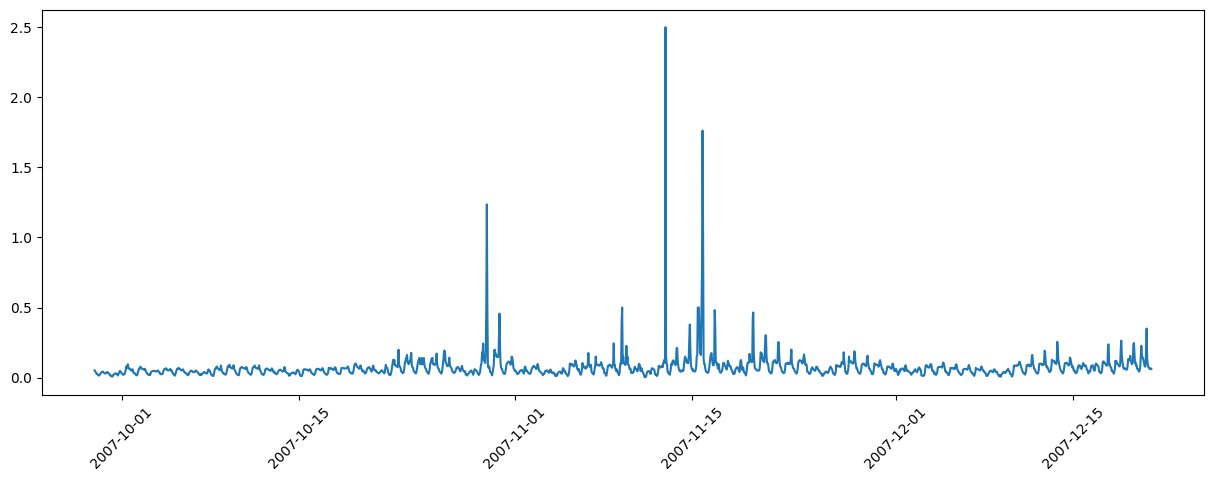

In [38]:
start = 6500
range = 2000
plt.figure(figsize=(15,5))
plt.plot(train['datetime'][start:(start+range)], train['price'][start:(start+range)])
plt.xticks(rotation=45)
plt.show()

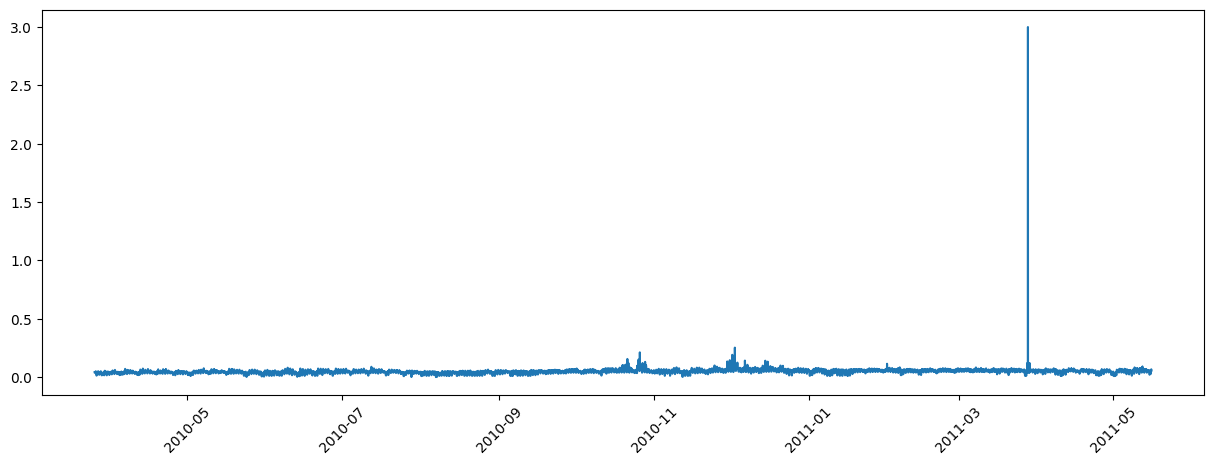

In [33]:
start = 2000
range = 10000
plt.figure(figsize=(15,5))
plt.plot(val['datetime'][start:(start+range)], val['price'][start:(start+range)])
plt.xticks(rotation=45)
plt.show()

In [3]:
price_horizon = 48
future_horizon = 0

env = gym.make('gym_env/BatteryGrid-v0')
env.setup(val, price_horizon=price_horizon, future_horizon=future_horizon, verbose=True)
obs,_ = env.reset()
print(obs)

obs,r,t,info = env.step(0)
obs,r,t,info = env.step(1)
obs,r,t,info = env.step(2)
obs,r,t,info = env.step(3)
obs,r,t,info = env.step(4)
obs,r,t,info = env.step(5)
obs,r,t,info = env.step(6)
obs,r,t,info = env.step(7)
obs,r,t,info = env.step(8)
obs,r,t,info = env.step(9)
obs,r,t,info = env.step(10)
obs,r,t,info = env.step(11)




{'battery': -0.5, 'prices': array([-0.76523653, -0.76929427, -0.85788829, -1.01614022, -1.07430118,
       -1.17642101, -1.38336583, -1.59031066, -1.08985586, -1.04183925,
       -0.96947619, -0.74089008, -0.43926462, -0.6421517 , -0.80716652,
       -0.96947619, -0.99449893, -0.38719027, -0.12276077,  0.37498886,
        0.18833275, -0.03957707,  0.60695643,  0.44261789, -0.10247207,
       -0.47781316, -0.36487269, -0.7949933 , -0.9687999 , -0.84706765,
       -0.59954541, -0.06865755,  0.29653919,  0.85244979,  1.17030622,
        1.36440153,  1.52062458,  1.12499477,  0.99649962,  0.70569481,
        0.86191786,  1.50980393,  2.16242404,  2.13266727,  1.41918104,
        1.00123365,  1.25010847,  1.11958445]), 'hour': -0.4583333333333333, 'day': -0.4904109589041096, 'presence': 1, 'tensor': array([-0.5       , -0.76523653, -0.76929427, -0.85788829, -1.01614022,
       -1.07430118, -1.17642101, -1.38336583, -1.59031066, -1.08985586,
       -1.04183925, -0.96947619, -0.74089008, -0.4

/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:189: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'dict'>`
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:213: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  log

In [13]:
action = 2
kWh = (6 - action) * 5 # Discretize, such that action 0 means most discharge, i.e., kWh = (5 - 0)* 5 = 25
kWh  -= 2.23 if action == 0 else 0 # Add charging loss

print(kWh)

20
